In [4]:
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm

In [5]:
df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
df.set_index('date', inplace = True)
# df.head(2)

In [6]:
df.head(3)

,price,month,year,day_of_week,100414,100415,100416,100442,100448,100458,100462,100467,100476,101448
date,,,,,,,,,,,,,,
2019-12-05,1280.0640,12,2019,3,1276.3752,1273.1431,1283.8037,1282.1858,1285.4796,1288.9269,1280.4603,1282.5865,1292.0920,1286.2476
2019-12-06,1275.9003,12,2019,4,1271.0579,1269.7292,1278.9882,1279.1871,1282.1477,1286.1161,1277.9297,1277.9011,1284.2635,1283.0789
2019-12-07,1272.5594,12,2019,5,1267.8539,1267.1099,1275.4015,1276.7167,1279.7073,1283.8757,1275.2665,1274.5820,1280.6549,1280.5310


In [7]:
max_forecast_days = 30

In [8]:
order = (5, 1, 1)  # p, d, q
seasonal_order = (1, 1, 1, 7) # P, D, Q, m
train, test = df[:df.shape[0]-max_forecast_days], df[df.shape[0]-max_forecast_days:]
nodes = df.columns.to_list()[4:] # getting the neighbors nodes names

In [9]:
# Getting forecast for neighbors
warnings.filterwarnings('ignore')
neighbor_predictions = {}
for node in nodes:
    print('working for:', node)
    model_fit = sm.tsa.statespace.SARIMAX(train[node], order=order, seasonal_order = seasonal_order).fit()
    curr_yhat = model_fit.forecast(max_forecast_days)
    neighbor_predictions[node] = curr_yhat
    print("RMSE:", mse(test[node], curr_yhat, squared=False))
#saving
import pickle
with open('neighbor_predictions_sarimax.pickle', 'wb') as handle:
    pickle.dump(neighbor_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

working for: 100414
RMSE: 114.91987705796618
working for: 100415
RMSE: 116.15582215343068
working for: 100416
RMSE: 117.52803555205969
working for: 100442
RMSE: 118.9324059533554
working for: 100448
RMSE: 119.67364225165858
working for: 100458
RMSE: 119.59239529772302
working for: 100462
RMSE: 119.39800320496259
working for: 100467
RMSE: 118.96181059140919
working for: 100476
RMSE: 118.01800847695247
working for: 101448
RMSE: 119.5100654304768


In [12]:
exogs = pd.DataFrame.from_dict(neighbor_predictions)

In [13]:
exogs.head(3)

,100414,100415,100416,100442,100448,100458,100462,100467,100476,101448
2023-10-04,1708.382208,1711.343032,1721.551813,1722.866478,1732.165192,1738.491354,1720.919272,1731.833346,1737.852896,1731.221258
2023-10-05,1706.566097,1709.384530,1719.880408,1720.252857,1730.645438,1736.341577,1718.323086,1730.640798,1734.346081,1729.648776
2023-10-06,1713.587800,1714.420981,1722.752526,1723.027575,1731.282596,1737.671354,1720.319144,1730.638097,1736.481119,1730.662276


(array([19635., 19639., 19643., 19647., 19651., 19655., 19659., 19662.]),
 [Text(19635.0, 0, '2023-10-05'),
  Text(19639.0, 0, '2023-10-09'),
  Text(19643.0, 0, '2023-10-13'),
  Text(19647.0, 0, '2023-10-17'),
  Text(19651.0, 0, '2023-10-21'),
  Text(19655.0, 0, '2023-10-25'),
  Text(19659.0, 0, '2023-10-29'),
  Text(19662.0, 0, '2023-11-01')])

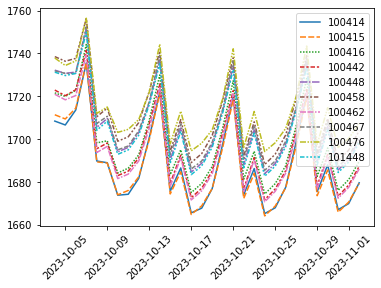

In [19]:
g = sns.lineplot(data=exogs)
plt.xticks(rotation=45)

In [14]:
# Forecast with ALL exog variable
warnings.filterwarnings('ignore')
model_fit = sm.tsa.statespace.SARIMAX(endog=train['price'], exog=train[nodes], order=order, seasonal_order = seasonal_order).fit()
yhat = model_fit.forecast(max_forecast_days, exog = exogs)

rmse_res = mse(test['price'], yhat, squared=False)
mape_res = mape(test['price'], yhat)
print("RMSE:", round(rmse_res, 2), "MAPE:", round(mape_res,3))

RMSE: 117.66 MAPE: 0.06


<Axes: xlabel='date'>

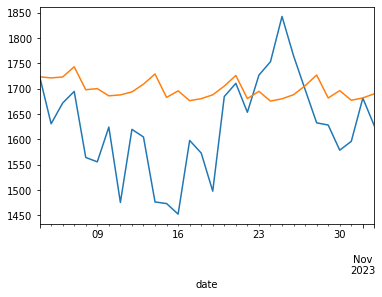

In [15]:
test['price'].plot()
yhat.plot()

In [22]:
# adding neighbor one-by-one
warnings.filterwarnings('ignore')
exogs = pd.DataFrame.from_dict(neighbor_predictions)
d = {}
for i in range (1,len(nodes)+1):
    curr_neighbors = nodes[:i]
    # print(curr_neighbors)
    model_fit = sm.tsa.statespace.SARIMAX(endog=train['price'], exog=train[curr_neighbors], order=order, seasonal_order = seasonal_order).fit()
    curr_yhat = model_fit.forecast(max_forecast_days, exog = exogs[curr_neighbors])
    rmse_sarima = mse(test['price'], curr_yhat, squared=False)
    print("Nodes No:",len(curr_neighbors), "RMSE:", rmse_sarima)
    d[len(curr_neighbors)]=rmse_sarima

Nodes No: 1 RMSE: 117.87468486440623
Nodes No: 2 RMSE: 117.63306623709704
Nodes No: 3 RMSE: 118.0325279524539
Nodes No: 4 RMSE: 116.4388994094224
Nodes No: 5 RMSE: 117.77529629570589
Nodes No: 6 RMSE: 117.87609098788255
Nodes No: 7 RMSE: 117.67931081686207
Nodes No: 8 RMSE: 117.65244584393503
Nodes No: 9 RMSE: 117.64373769253629
Nodes No: 10 RMSE: 117.66352006166737
